# MANU 465 - Exploring Brainwaves vs Creative and Analytical Tasks
### By: Emilie Ho (#57204216), Faith Tan (), and Pan Tisapramotkul (#79074373)

## Project Overview and Summary

## General Setup 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Define Constants used

In [2]:
### CONSTANTS ###

SAMPLING_RATE = 256
SAMPLE_SECOND = 20
PREFERRED_DIR = r'preference_dataset\Preferred'
NON_PREFERRED_DIR = r'preference_dataset\Not Preferred'
RAW_CHANNEL = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']
BRAINWAVES = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
SEED = 42

## Importing the Raw Data Collected

### Import Raw Data for Math vs Drawing Files

#### Testing, Training and Data Leakage

Initially, we used the <code> train_test_split() </code> method to divide the dataset into training and testing sets. However, this was done after slicing the 5-minute recordings into 20-second intervals. Following model training, we observed an unusually high accuracy of 95%.

Upon investigation, we identified **data leakage** as the issue. The models were likely recognizing 20-second samples that originated from the same file, leading to overlap between the training and testing sets.

To address this, we opted for a manual approach: randomly selecting 20% of the files as the testing set before slicing the data into intervals. 

In [6]:
import os
import random
from math import floor

# Get all the files path in the mathematical and creative directories appened in a list
preferred_files = [os.path.join(PREFERRED_DIR, file) for file in os.listdir(PREFERRED_DIR) if os.path.isfile(os.path.join(PREFERRED_DIR, file))]
non_preferred_files = [os.path.join(NON_PREFERRED_DIR, file) for file in os.listdir(NON_PREFERRED_DIR) if os.path.isfile(os.path.join(NON_PREFERRED_DIR, file))]

# Get two random files in the mathematical directory as test files
preferred_test_indices = random.sample(range(len(preferred_files)), floor(len(preferred_files) * 0.2))
preferred_test_files = [preferred_files[i] for i in preferred_test_indices]
preferred_train_files = [preferred_files[i] for i in range(len(preferred_files)) if i not in preferred_test_indices]

# Get two random files in the creative directory as test files
non_preferred_test_indices = random.sample(range(len(non_preferred_files)), floor(len(non_preferred_files) * 0.2))
non_preferred_test_files = [non_preferred_files[i] for i in non_preferred_test_indices]
non_preferred_train_files = [non_preferred_files[i] for i in range(len(non_preferred_files)) if i not in non_preferred_test_indices]

# Print files name
print('Preferred train files:', (preferred_train_files))
print(' files:', (preferred_test_files))
print('Creative train files:', (non_preferred_train_files))
print('Creative test files:', (non_preferred_test_files))

print("\nSuccessfully loaded data!")

Preferred train files: ['preference_dataset\\Preferred\\mindMonitor_2024-11-21--01-55-57.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--02-02-03.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--21-33-30.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--22-11-03.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--23-05-07.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--23-07-13.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--23-09-06.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-30--20-23-31.csv', 'preference_dataset\\Preferred\\mindMonitor_2567-11-20--00-40-16.csv', 'preference_dataset\\Preferred\\mindMonitor_2567-11-20--00-46-48.csv']
 files: ['preference_dataset\\Preferred\\mindMonitor_2024-11-21--02-16-51.csv', 'preference_dataset\\Preferred\\mindMonitor_2024-11-21--02-10-24.csv']
Creative train files: ['preference_dataset\\Not Preferred\\mindMonitor_2024-11-19--13-56-12.csv', 'preference_datas

## Data Preprocessing

### Divide Data into 20 seconds samples

In [4]:
from scipy.signal import hilbert
from math import floor, ceil


def divide_data(data, size):
    # Split the DataFrame into chunks
    num_chunks = floor(len(data) / size)
    data_list = []  # List to store chunks

    for i in range(num_chunks):
        start_idx = i * size
        end_idx = start_idx + size
        data_list.append(data.iloc[start_idx:end_idx])

    return data_list

### Clean up data
As a part of initial preprocessing, create function that will drop unncessary columns, calculate average, smooth out data, envolope brainwaves

In [5]:
def cleaned_up_data(file : str):
    # convert .csv into a dataframe
    dataset = pd.read_csv(file)
    
    # drop unecessary columns and NaN values
    dataset.drop(columns=['Battery','Elements'], inplace=True)
    dataset = dataset.dropna()
    
    # smoothen the data by using moving average and calculate the envelope
    for i in BRAINWAVES:
        average_col_name = i + ' Average'
        smooth_col_name = i + ' Smoothen'
        envelope_col_name = i + ' Envelope'

        dataset[average_col_name] = ((dataset[i + '_TP9'] + dataset[i + '_TP10'] + dataset[i + '_AF7'] + dataset[i + '_AF8']) / 4) * 100
        dataset[smooth_col_name] = moving_average(dataset[average_col_name].values, 1000)
        dataset[envelope_col_name] = np.abs(hilbert(dataset[smooth_col_name].values))

    return dataset

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

### Get data by looping through each .csv file

In [13]:

def get_all_data(file_list: list):
    """get data from all the files in the directory, 
    divide it into 20 seconds intervals and return the data"""

    all_data = []

    # Transform each file in a list into a cleaned and processed dataframe
    for file in file_list:
        dataset = cleaned_up_data(file)
        data_list = divide_data(dataset, size=SAMPLING_RATE * SAMPLE_SECOND)
        all_data.extend(data_list)
    
    return all_data

preferred_test_data : list[pd.DataFrame] = get_all_data(preferred_test_files)
preferred_train_data : list[pd.DataFrame] = get_all_data(preferred_train_files)
non_prepferred_test_data : list[pd.DataFrame] = get_all_data(non_preferred_test_files)
non_preferred_train_data : list[pd.DataFrame] = get_all_data(non_preferred_train_files)

print("\nSuccessfully get and cleaned up data!")


C:\Users\piram\AppData\Local\Temp\ipykernel_28516\603071745.py:3: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file)



Successfully get and cleaned up data!


### Visualizing Cleaned Up Data

In [14]:
sample = preferred_test_data[0]
sample.head()


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Theta Envelope,Alpha Average,Alpha Smoothen,Alpha Envelope,Beta Average,Beta Smoothen,Beta Envelope,Gamma Average,Gamma Smoothen,Gamma Envelope
1,2024-11-21 02:16:51.436,0.593762,0.938667,-0.273103,-0.036731,0.58885,0.660692,0.236783,0.17474,0.911421,...,26.519225,47.037178,20.163823,52.584405,34.274694,11.499788,66.931937,-6.335262,-5.704561,90.388171
2,2024-11-21 02:16:51.437,0.593762,0.938667,-0.273103,-0.036731,0.58885,0.660692,0.236783,0.17474,0.911421,...,27.316768,47.037178,20.200174,42.265259,34.274694,11.520341,55.271237,-6.335262,-5.715916,77.958078
3,2024-11-21 02:16:51.437,0.593762,0.938667,-0.273103,-0.036731,0.58885,0.660692,0.236783,0.17474,0.911421,...,27.444812,47.037178,20.236524,42.128766,34.274694,11.540894,55.141959,-6.335262,-5.727271,77.930844
4,2024-11-21 02:16:51.437,0.593762,0.938667,-0.273103,-0.036731,0.58885,0.660692,0.236783,0.17474,0.911421,...,27.785612,47.037178,20.272874,38.767430,34.274694,11.561448,51.209625,-6.335262,-5.738626,73.775410
5,2024-11-21 02:16:51.438,0.593762,0.938667,-0.273103,-0.036731,0.58885,0.660692,0.236783,0.17474,0.911421,...,27.899016,47.037178,20.308680,38.657356,34.274694,11.581990,51.098340,-6.335262,-5.749787,73.751964


### Raw Data Structure

In [15]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5120 entries, 1 to 5127
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TimeStamp        5120 non-null   object 
 1   Delta_TP9        5120 non-null   float64
 2   Delta_AF7        5120 non-null   float64
 3   Delta_AF8        5120 non-null   float64
 4   Delta_TP10       5120 non-null   float64
 5   Theta_TP9        5120 non-null   float64
 6   Theta_AF7        5120 non-null   float64
 7   Theta_AF8        5120 non-null   float64
 8   Theta_TP10       5120 non-null   float64
 9   Alpha_TP9        5120 non-null   float64
 10  Alpha_AF7        5120 non-null   float64
 11  Alpha_AF8        5120 non-null   float64
 12  Alpha_TP10       5120 non-null   float64
 13  Beta_TP9         5120 non-null   float64
 14  Beta_AF7         5120 non-null   float64
 15  Beta_AF8         5120 non-null   float64
 16  Beta_TP10        5120 non-null   float64
 17  Gamma_TP9        51

## EEG Feature Extraction

Get the peaks' amplitude, frequency, and area under the curve from the raw data collected by the four electrodes

In [37]:
from scipy.signal import find_peaks
from numpy import trapezoid #type: ignore
from typing import List, Tuple

def get_fft(dataset : pd.DataFrame, channel : str) -> Tuple[np.ndarray, np.ndarray]:
    """Perform FFT on the data of the channel specfied from the range of 0.5 to 50 Hz

    Args:
        dataset (pd.DataFrame): _description_
        channel (str): _description_

    Returns:
        _type_: _description_
    """
    dataset_ch = dataset[channel]

    # Perform FFT 
    n = len(dataset_ch)                 # length of the signal
    k = np.arange(n)
    T = n/SAMPLING_RATE
    frq = k/T                 # two sides frequency range
    zz=int(n/2)

    freq = frq[range(zz)]           # one side frequency range
    Y = np.fft.fft(dataset_ch)/n              # fft computing and normalization
    Y = abs(Y[range(zz)])

    # get only frequency from 0.5 to 55 Hz
    freq_mask = (freq>0.5) & (freq<55)
    filtered_freq = freq[freq_mask]
    filtered_Y = Y[freq_mask]
    
    return filtered_freq, filtered_Y
    
def get_peaks(filtered_freq, filtered_Y) -> Tuple[List[float], np.ndarray]:
    """_summary_

    Args:
        filtered_freq (_type_): _description_
        filtered_Y (_type_): _description_

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """

    if max(filtered_freq) > 60:
        raise ValueError("Warning: Detected frequency Higher than 60 Hz. Please remove it before continuing")
    
    # Get the peaks
    peaks, properties = find_peaks(filtered_Y, height=5)
    peak_heights = properties['peak_heights']

    # Get top 5 peaks
    if len(peaks) > 5:
        top_5_indices = np.argsort(peak_heights)[-5:][::-1]  # Indices of top 5 peaks
        peaks = peaks[top_5_indices]
        peak_heights = peak_heights[top_5_indices]
    
    # Sort the top 5 peaks in chronological order (by their indices)
    sorted_indices = np.argsort(peaks)
    peaks = peaks[sorted_indices]
    peak_heights = peak_heights[sorted_indices]

    return [filtered_freq[i] for i in peaks], peak_heights

def get_fft_area(freq, filtered_Y):
    """_summary_

    Args:
        freq (_type_): _description_
        filtered_Y (_type_): _description_

    Returns:
        _type_: _description_
    """
    gamma_mask = (freq>30) & (freq<55)
    beta_mask = (freq>13) & (freq<30)
    alpha_mask = (freq>8) & (freq<13)
    theta_mask = (freq>4) & (freq<8)
    delta_mask = (freq>1) & (freq<4)

    frequency_masks = [gamma_mask, beta_mask, alpha_mask, theta_mask, delta_mask]

    return [trapezoid(filtered_Y[mask], dx=1) for mask in frequency_masks]

def get_area_under_db_curve(data, dx=1):
    return [trapezoid(data[y + ' Envelope'], dx=1) for y in BRAINWAVES] 

def find_max_electrode(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """

    mean_dict = {
        'RAW_AF7': float(data['RAW_AF7'].abs().max() - data['RAW_AF7'].abs().min()), 
        'RAW_AF8': float(data['RAW_AF8'].abs().max() - data['RAW_AF8'].abs().min()), 
        'RAW_TP9': float(data['RAW_TP9'].abs().max() - data['RAW_TP9'].abs().min()), 
        'RAW_TP10': float(data['RAW_TP10'].abs().max() - data['RAW_TP10'].abs().min())
        }

    return max(mean_dict, key=mean_dict.get) 

def feature_extraction(all_data: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Extracts features from a list of dataframes and compiles them into a DataFrame.
    
    Parameters:
        all_data (list[pd.DataFrame]): A list of pandas DataFrames containing input data.
    
    Returns:
        pd.DataFrame: A DataFrame containing the extracted features for each input.
    """

    feature_data = []

    # Process each file in the input list
    for data in all_data:
        try:
            data_info = []
            # Identify the channel with maximum raw data
            channel = find_max_electrode(data)
            
            # Perform FFT and extract peaks
            freq, y = get_fft(data, channel)
            peaks, peak_heights = get_peaks(freq, y)  # type: ignore

            if len(peaks) < 5:
                continue
            # Calculate areas
            area = get_fft_area(freq, y)
            db_area = get_area_under_db_curve(data)

            # Combine all extracted features
            data_info.extend(peaks)
            data_info.extend(peak_heights)
            data_info.extend(area)
            data_info.extend(db_area)
            feature_data.append(data_info)

        except Exception as e:
            print(e)
            continue

    # Convert the list of feature data into a DataFrame
    feature_df = pd.DataFrame(feature_data)

    return feature_df

def plot_samples(files: list[str], channel = None):
    """
    Plot the FFT of the data from the given list of files.
    
    Args:
        files (list[str]): List of file paths to process and plot.
        channel (int, optional): Specific channel to analyze. Defaults to the channel with maximum data.
    """
    plt.figure(figsize=(12, 20))

    num_files = len(files)

    for i, file in enumerate(files):
        # Process data from the file
        data = cleaned_up_data(file)

        # Determine channel to use
        max_channel = find_max_electrode(data) if channel is None else channel

        # Perform FFT and plot
        freq, y = get_fft(data, max_channel)
        ax = plt.subplot(ceil(num_files / 2), 2, i + 1)
        ax.plot(freq, y)
        ax.set_title(file)
        ax.set_xlim(0.5, 55)
        ax.set_ylim(0, 85)

        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def plot_raw_data(dataset : pd.DataFrame):
    """
    Plot raw data envelopes over time with shaded areas under the curves.
    
    Args:
        dataset (pd.DataFrame): A DataFrame containing time and envelope data for plotting.
    """
    
    dataset.plot(x='TimeStamp', y=['Delta_envelope', 'Theta_envelope', 'Alpha_envelope', 'Beta_envelope', 'Gamma_envelope'], figsize=(20, 10))
    
    for i in ['Delta_envelope', 'Theta_envelope', 'Alpha_envelope', 'Beta_envelope', 'Gamma_envelope']:
        plt.fill_between(data=dataset, x=range(len(dataset)), y1=i, y2=0, alpha=0.3)

    plt.ylim(0, 100)
    plt.show()

# Perform FFT on the data
all_features_preferred_test = feature_extraction(preferred_test_data)
all_features_preferred_train = feature_extraction(preferred_train_data)
all_features_non_preferred_test = feature_extraction(non_prepferred_test_data)
all_features_non_preferred_train = feature_extraction(non_preferred_train_data)

print("\nSuccessfully extracted features!")

# Print lengths to confirm 
print(len(all_features_non_preferred_test))
print(len(all_features_non_preferred_train))
print(len(all_features_preferred_test))
print(len(all_features_preferred_train))

# Add labels to the data
all_features_preferred_test['label'] = 1
all_features_preferred_train['label'] = 1
all_features_non_preferred_test['label'] = 0
all_features_non_preferred_train['label'] = 0

print("\nSuccessfully extracted features!")


Successfully extracted features!
41
142
25
115

Successfully extracted features!


## Exploratory Data Analysis

### Splitting Dateset into the Training and Test Sets

In [38]:
from sklearn.model_selection import train_test_split

# Combine the testing dataFrames
train_combined_df = pd.concat([all_features_preferred_train, all_features_non_preferred_train], ignore_index=True)

# Comgine the training dataFrames
test_combined_df = pd.concat([all_features_preferred_test, all_features_non_preferred_test], ignore_index=True)

# Shuffle the DataFrame
all_train_df = train_combined_df.sample(frac=1).reset_index(drop=True)
all_train_df.dropna(inplace=True)
all_train_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']

all_test_df = test_combined_df.sample(frac=1).reset_index(drop=True)
all_test_df.dropna(inplace=True)
all_test_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']

# combine all the data for Exploratory Data Analysis
all_df = pd.concat([all_train_df, all_test_df], ignore_index=True)

### Plotting Histograms

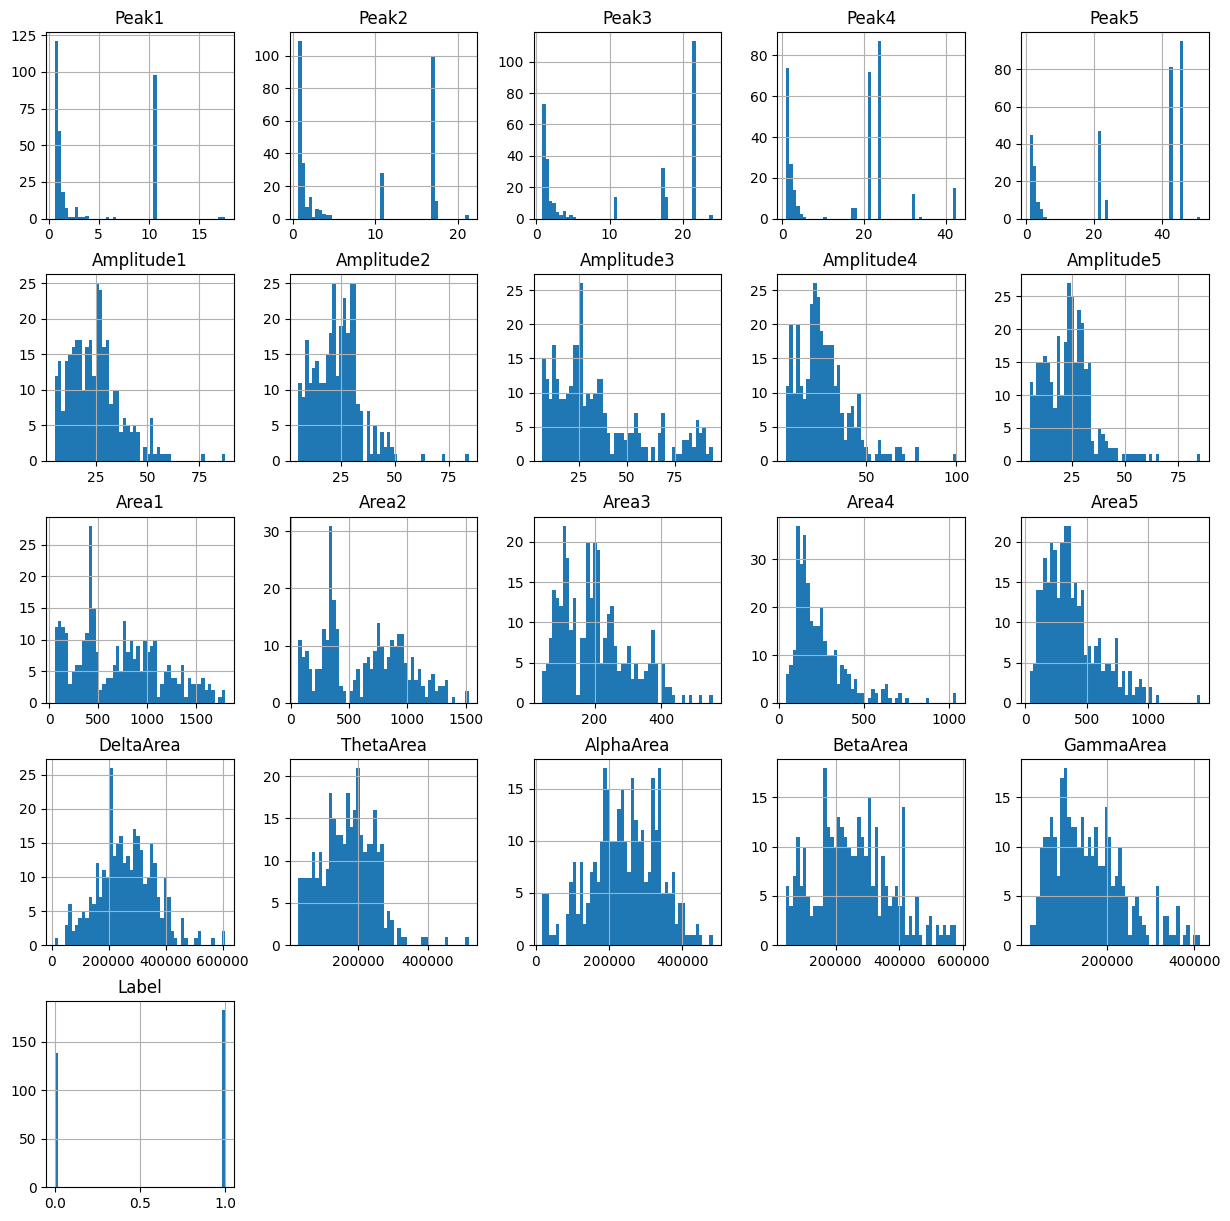

In [31]:
all_df[:-1].hist(bins=50, figsize=(15,15))
plt.show()


### Correlation Matrix

Label         1.000000
GammaArea     0.423851
BetaArea      0.258657
DeltaArea     0.245654
AlphaArea     0.217598
Peak1         0.144533
Peak4         0.130835
Amplitude3    0.128258
Amplitude2    0.105188
Peak3         0.105099
Peak5         0.096727
Peak2         0.090600
Amplitude5    0.031931
Amplitude1    0.025391
Amplitude4   -0.098383
Area2        -0.106778
Area5        -0.119255
ThetaArea    -0.145427
Area1        -0.151853
Area3        -0.187474
Area4        -0.249619
Name: Label, dtype: float64

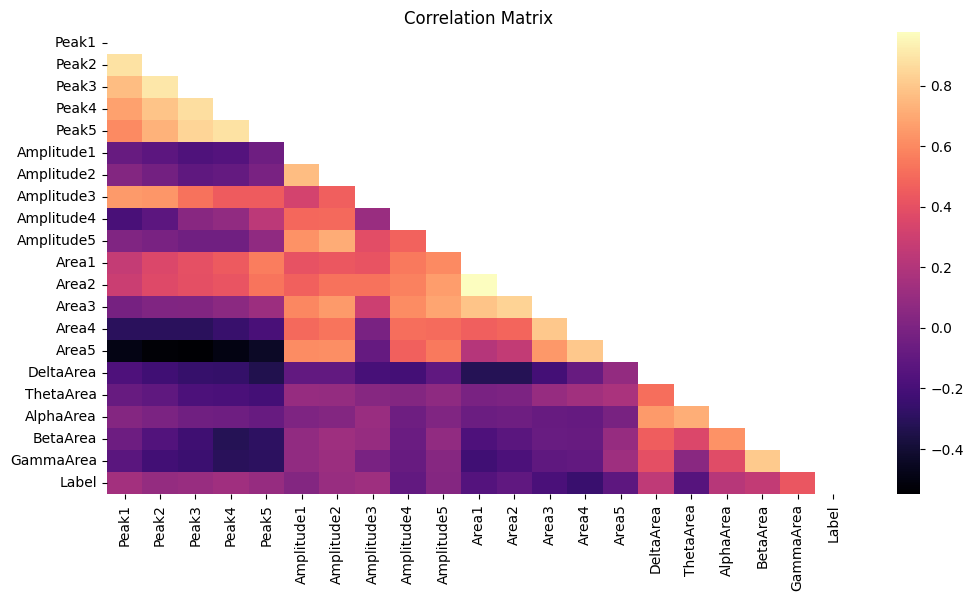

In [39]:
from seaborn import heatmap

# creating the correlation matrix
corr_matrix = all_df.corr()

# visualizing the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
plt.figure(figsize=(12, 6))  # to set the figure size
heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")  # to add title 
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# getting the correlation values with the purchased column
corr_matrix['Label'].sort_values(ascending=False)  

### Graph 1: Showing Correlationship between area under each frequency range (Brain activity) and the type of task (Drawing vs Math)

Amount of data where label is 0: 183
Amount of data where label is 1: 140


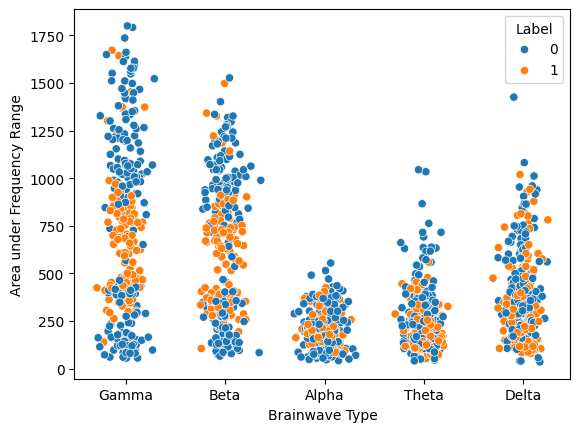

In [40]:
for i in range(5):
    if i == 0:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=True)
    else:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=False)

d.set_ylabel('Area under Frequency Range')
d.set_xlabel('Brainwave Type')
d.set_xticks([0,1,2,3,4])
d.set_xticklabels(['Gamma', 'Beta', 'Alpha', 'Theta', 'Delta'])

print("Amount of data where label is 0:", len(all_df[all_df['Label'] == 0]))
print("Amount of data where label is 1:", len(all_df[all_df['Label'] == 1]))

## Data Preprocessing Pt. 2

### Manual Test and Train Splitting (To prevent data leakage)

In [41]:
X_train = all_train_df.iloc[:, :-1]
X_test = all_test_df.iloc[:, :-1]
y_train = all_train_df.iloc[:, -1]
y_test = all_test_df.iloc[:, -1]

In [42]:
# Applying log transform to a column
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5']:
    all_df[col] = np.log(all_df[col] + 1)  # Add 1 to avoid log(0)

### Removing Outliers using IQW Method

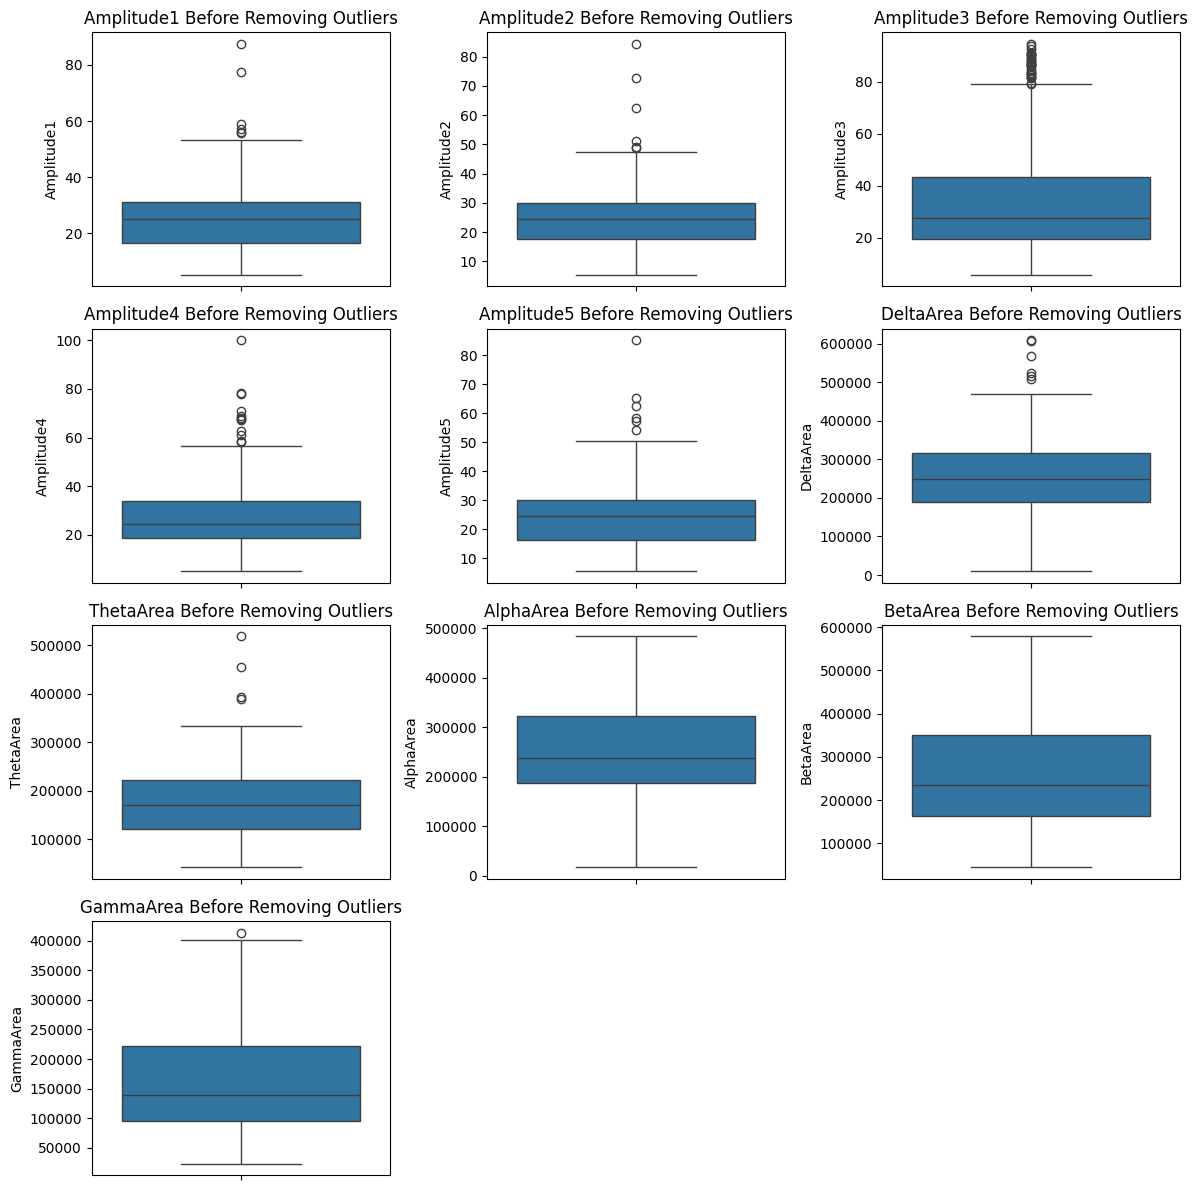

In [43]:
# Plot data before remoivng outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

In [44]:
# Function to remove outliers and corresponding rows from X and y
def remove_outliers_from_both(X, y, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.2 * IQR
    upper_bound = Q3 + 1.2 * IQR

    # Keep only the rows where the values are within the bounds
    mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
    
    # Return the filtered X and y (rows without outliers)
    return X[mask], y[mask]

# Remove outliers from Amplitudes
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']:
    X_train, y_train = remove_outliers_from_both(X_train, y_train, col)

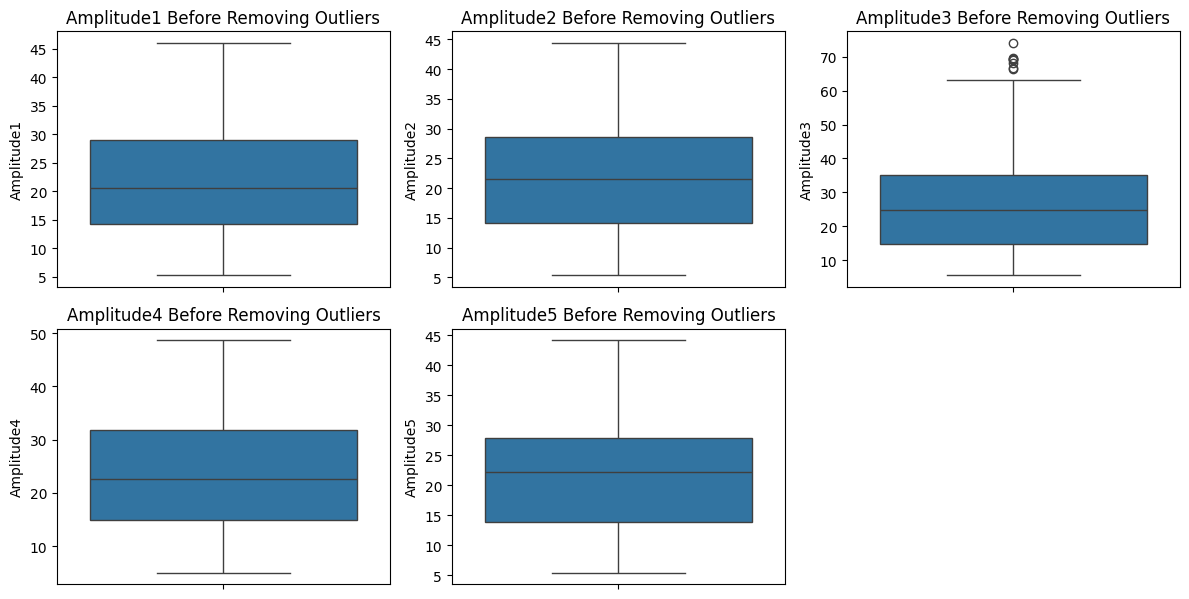

In [45]:
# Plot data after removing outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

### Feature Scaling

In [46]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Principal Component Analysis (PCA)

        Peak1     Peak2     Peak3     Peak4     Peak5  Amplitude1  Amplitude2  \
PC1  0.132989  0.176878  0.161679  0.176849  0.202844    0.242644    0.253897   
PC2 -0.288948 -0.334250 -0.362575 -0.347701 -0.307319    0.218057    0.229089   

     Amplitude3  Amplitude4  Amplitude5     Area1     Area2     Area3  \
PC1    0.255209    0.237819    0.290459  0.348380  0.361919  0.336216   
PC2   -0.071653    0.169104    0.184179 -0.039148 -0.014913  0.151208   

        Area4     Area5  DeltaArea  ThetaArea  AlphaArea  BetaArea  GammaArea  
PC1  0.244552  0.145338  -0.138756  -0.019238  -0.080241 -0.125556  -0.186870  
PC2  0.264297  0.368067   0.076037   0.132452   0.043667  0.149975   0.112392  
Explained Variance (Retained): 0.5878
Information Loss: 0.4122


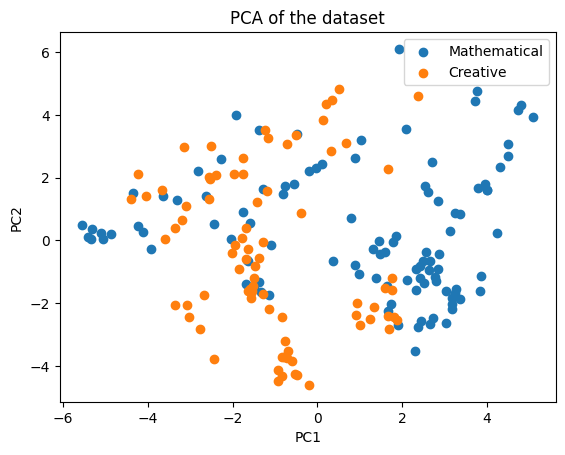

In [47]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X_train)
Z=pca.transform(X_train)

loadings = pd.DataFrame(
    pca.components_,
    columns=all_df.columns[:-1],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings.head())


# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.sum(explained_variance_ratio)

# Calculate information loss
information_loss = 1 - cumulative_explained_variance

print(f"Explained Variance (Retained): {cumulative_explained_variance:.4f}")
print(f"Information Loss: {information_loss:.4f}")

plt.scatter(Z[y_train == 0, 0], Z[y_train == 0, 1], label='Mathematical')
plt.scatter(Z[y_train == 1, 0], Z[y_train == 1, 1], label='Creative')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the dataset')
plt.show()

## Building Machine Learning Model: SVM

### Compiling SVM

In [48]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state=0) ## try differernals and remove the random_state maybe
classifier.fit(X_train, y_train)

SVC(random_state=0)

### Evaluating SVM

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("Your Model Testing Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")
print("Your Model Training Accuracy is=", accuracy_score(y_train, y_pred_train)*100, "%")

[[22 19]
 [ 6 19]]
Your Model Testing Accuracy is= 62.121212121212125 %
Your Model Training Accuracy is= 96.80851063829788 %


## Building Machine Learning Model: KNN

## Building Machine Learning Model: Artificial Neural Network (ANN)

## Building Machine Learning Model: Convolutional Neural Network (CNN)

In [50]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")
print("Your Model Training Accuracy is=", accuracy_score(y_train, y_pred_train)*100, "%")

[[19 22]
 [ 4 21]]
Your Model Accuracy is= 60.60606060606061 %
Your Model Training Accuracy is= 95.74468085106383 %


### Neural Network (ANN) Model

### Import Libraries

In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint


### Basic ANN Model

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4240 - loss: 0.8592 - val_accuracy: 0.4848 - val_loss: 0.6730
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5520 - loss: 0.6663 - val_accuracy: 0.4545 - val_loss: 0.6921
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7266 - loss: 0.6014 - val_accuracy: 0.3788 - val_loss: 0.7229
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7567 - loss: 0.5419 - val_accuracy: 0.3485 - val_loss: 0.7424
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7988 - loss: 0.4822 - val_accuracy: 0.3788 - val_loss: 0.7603
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.3939 - val_accuracy: 0.4545 - val_loss: 0.7695
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8566 - loss: 0.3944 - val_accuracy: 0.6212 - val_loss: 0.7649
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.3696 - val_accuracy: 0.6212 - val_loss

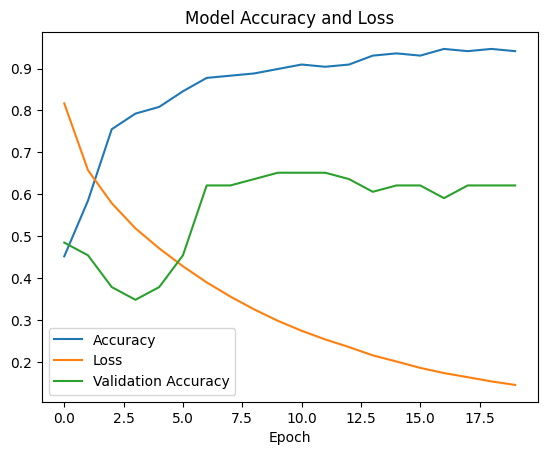

In [52]:
basicANNModdel = tf.keras.models.Sequential()
basicANNModdel.add(tf.keras.layers.Dense(20,activation='relu'))
basicANNModdel.add(tf.keras.layers.Dense(units=12, activation='relu'))
basicANNModdel.add(tf.keras.layers.Dense(1,activation='sigmoid'))

basicANNModdel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = basicANNModdel.fit(X_train, 
                            y_train,
                            validation_data = (X_test, y_test),
                            batch_size = 8, 
                            epochs = 20)

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_accuracy'],  label='Validation Accuracy')
plt.title('Model Accuracy and Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()  


In [53]:
y_pred = basicANNModdel.predict(X_test)
basicANNModdel.evaluate(X_test,y_test)
basicANNModdel.evaluate(X_train, y_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6192 - loss: 1.2198
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9464 - loss: 0.1517


[0.13963855803012848, 0.9521276354789734]

### Tuning ANN model through the combination of grid and random search

In [54]:
# Define a function to create the ANN model
def create_model(n_layers=1, n_neurons=32, dropout_rate=0.0, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',  
        metrics=['accuracy']
    )
    return model

# Wrap the Keras model for compatibility with scikit-learn
model_wrapper = KerasClassifier(
    model=create_model,
    verbose=0  # Suppress training logs
)

# Step 1: Grid Search for critical hyperparameters
grid_params = {
    'model__n_layers': [2, 3],  # Number of hidden layers
    'model__n_neurons': [12, 16, 32],  # Number of neurons per layer
    'batch_size': [8, 16]  # Batch size
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=grid_params,
    cv=3,
    scoring='accuracy',
    n_jobs=2
)

print("Running Grid Search...")
grid_search.fit(X_train, y_train)

# Get the best parameters from Grid Search
best_grid_params = grid_search.best_params_
print(f"Grid Search Best Parameters: {best_grid_params}")
print(f"Grid Search Best Validation Accuracy: {grid_search.best_score_}")

# Step 2: Random Search for less critical hyperparameters
# Update model with best parameters from Grid Search
model_wrapper.set_params(**best_grid_params)

random_params = {
    'model__learning_rate': uniform(0.0001, 0.01),  # Learning rate
    'model__dropout_rate': uniform(0, 0.5),  # Dropout rates
    'epochs': randint(10, 100)  # Integer range for number of epochs
}

random_search = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=random_params,
    n_iter=10,  # Number of random combinations to try
    cv=3,
    scoring='accuracy',
    n_jobs=2,
    random_state=42
)

print("Running Random Search...")
random_search.fit(X_train, y_train)

# Get the best parameters from Random Search
best_random_params = random_search.best_params_
print(f"Random Search Best Parameters: {best_random_params}")
print(f"Random Search Best Validation Accuracy: {random_search.best_score_}")

# Combine best parameters from both searches
combined_best_params = {**best_grid_params, **best_random_params}
print(f"Combined Best Parameters: {combined_best_params}")

# Train the final model with the best parameters
final_model = create_model(**{
    'n_layers': combined_best_params['model__n_layers'],
    'n_neurons': combined_best_params['model__n_neurons'],
    'dropout_rate': combined_best_params['model__dropout_rate'],
    'learning_rate': combined_best_params['model__learning_rate']
})

final_model.fit(
    X_train, y_train,
    epochs=combined_best_params['epochs'],
    batch_size=combined_best_params['batch_size'],
    verbose=1
)

# Predict on both train and test sets
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Convert predictions to class labels
y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Evaluate performance on train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nBest ANN Model Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Running Grid Search...


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Grid Search Best Parameters: {'batch_size': 8, 'model__n_layers': 2, 'model__n_neurons': 32}
Grid Search Best Validation Accuracy: 0.8672981737497866
Running Random Search...


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Random Search Best Parameters: {'epochs': 96, 'model__dropout_rate': np.float64(0.02904180608409973), 'model__learning_rate': np.float64(0.008761761457749352)}
Random Search Best Validation Accuracy: 0.9467485919098823
Combined Best Parameters: {'batch_size': 8, 'model__n_layers': 2, 'model__n_neurons': 32, 'epochs': 96, 'model__dropout_rate': np.float64(0.02904180608409973), 'model__learning_rate': np.float64(0.008761761457749352)}
Epoch 1/96


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7360 - loss: 0.5551
Epoch 2/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9147 - loss: 0.2461
Epoch 3/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9537 - loss: 0.1058
Epoch 4/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9019 - loss: 0.1850
Epoch 5/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9537 - loss: 0.1012
Epoch 6/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9590 - loss: 0.0662
Epoch 7/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9431 - loss: 0.0920
Epoch 8/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9847 - loss: 0.0509
Epoch 9/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.0618
Epoch 10/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0373
Epoch 11/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0287
Epoch 12/96
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0306
